## Sobre a necessidade de transformação de variáveis

A série apresenta \textbf{heterocedasticidade}, ou seja, a variância dos valores não é constante — tende a aumentar conforme o nível da série se eleva. Essa característica é comum em séries com crescimento de natureza exponencial ou multiplicativa, e pode comprometer o desempenho de modelos que assumem variância constante.

Assim, é recomendada a aplicação de uma \textbf{transformação de variáveis}, especialmente a \textit{transformação logarítmica} ou a \textbf{transformação de Box-Cox}. Testamos o uso das duas transformações nos dados, a segunda se saiu melhor na regressão e o desempenho de ambas nos erros dos modelos baselines não teve resultados significativos.

In [13]:
from scipy.stats import boxcox
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

In [14]:
# Carregar dados
df = pd.read_csv('data_updated.csv')

# indexando pelas datas
df['week_dt'] = pd.to_datetime(df['week'])
df.set_index('week_dt', inplace=True)
df.index.name = 'week'

# manter apenas coluna volume
series = df['volume'].astype(float)
series.name = 'volume'

Lambda estimado pelo Box-Cox: 0.0381


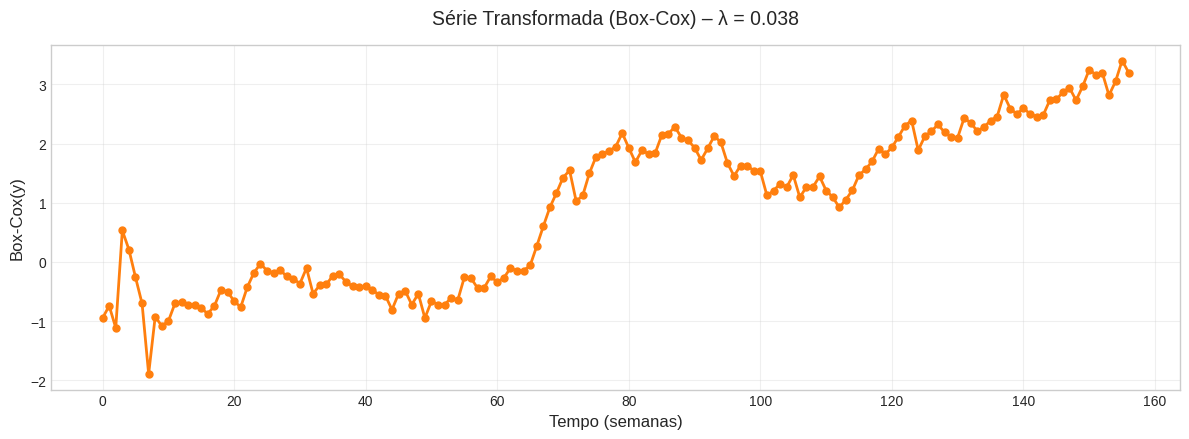

In [15]:
# Estilo global
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    "figure.figsize": (12, 4.5),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "lines.linewidth": 2,
    "lines.markersize": 5
})

# Preparação dos dados
df = df.sort_index()
y = df["volume"]

# Box-Cox exige valores estritamente positivos
# Caso haja zeros, deslocamos a série:
shift = 0
if (y <= 0).any():
    shift = abs(y.min()) + 1
    y_bc_input = y + shift
else:
    y_bc_input = y

# Transformação Box-Cox
y_boxcox, lambda_bc = boxcox(y_bc_input)

print(f"Lambda estimado pelo Box-Cox: {lambda_bc:.4f}")

# Plot
fig, ax = plt.subplots()
ax.plot(y_boxcox, marker='o', color='#ff7f0e')
ax.set_title(f"Série Transformada (Box-Cox) – λ = {lambda_bc:.3f}", pad=15)
ax.set_xlabel("Tempo (semanas)")
ax.set_ylabel("Box-Cox(y)")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Sobre a decomposição entre tendência e sazonalidade

A série apresenta \textbf{tendência de longo prazo} ($T_t$) e \textbf{sazonalidade periódica} ($S_t$). Assim, a série pode ser representada por:
$y_t = T_t + S_t + R_t$ ,
onde $R_t$ é o componente residual ou ruído. Então, essa decomposição seria necessária para, principalmente, isolar a tendência estrutural, identificar padrões sazonais, remover o efeito da sazonalidade e analisar o componente residual.

Após a decomposição, a série ajustada sazonalmente mostrou-se muito semelhante à série original o que indica que a tendência sobrepõe a sazonalidade na série temporal em questão, há pouca ou nenhuma sazonalidade.

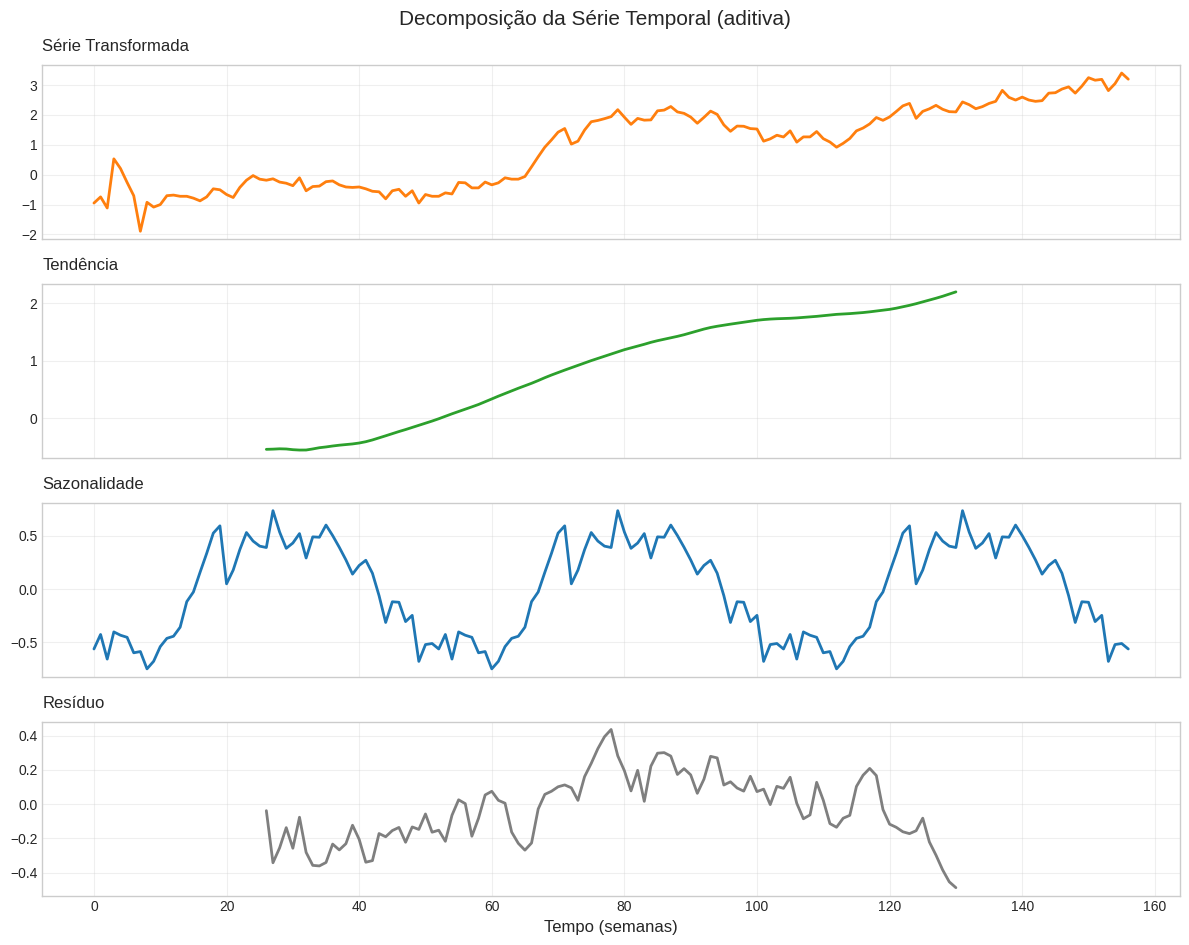

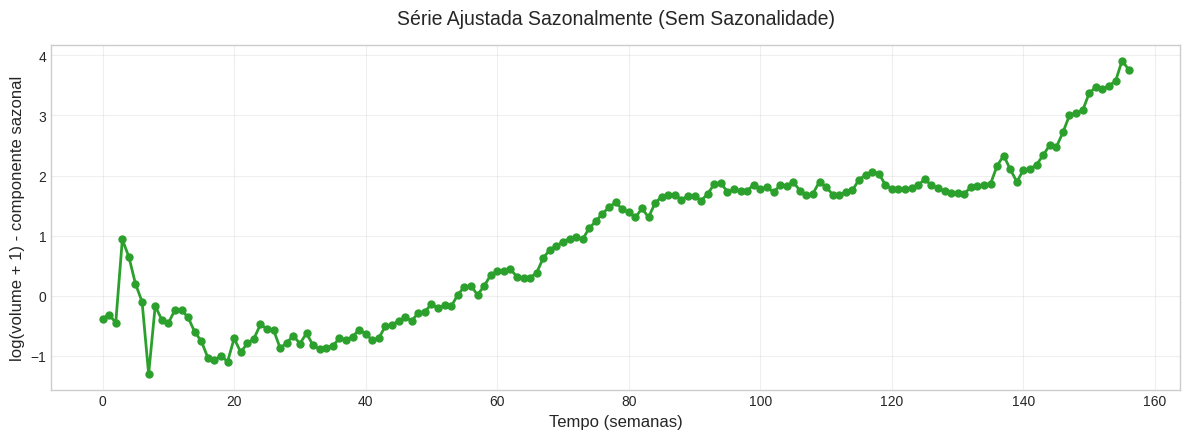

In [17]:
# decomposição aditiva, com período semanal aproximado
result = seasonal_decompose(y_boxcox, model='additive', period=52)

# visualização da decomposição
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
components = [y_boxcox, result.trend, result.seasonal, result.resid]
titles = ["Série Transformada", "Tendência", "Sazonalidade", "Resíduo"]
colors = ["#ff7f0e", "#2ca02c", "#1f77b4", "#7f7f7f"]

for i, ax in enumerate(axes):
    ax.plot(components[i], color=colors[i])
    ax.set_title(titles[i], loc='left', fontsize=12, pad=10)
    ax.grid(alpha=0.3)

axes[-1].set_xlabel("Tempo (semanas)")
plt.suptitle("Decomposição da Série Temporal (aditiva)", fontsize=15, y=0.94)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# série ajustada sazonalmente
y_adj = y_boxcox - result.seasonal

fig, ax = plt.subplots()
ax.plot(y_adj, color='#2ca02c', marker='o')
ax.set_title("Série Ajustada Sazonalmente (Sem Sazonalidade)", pad=15)
ax.set_xlabel("Tempo (semanas)")
ax.set_ylabel("log(volume + 1) - componente sazonal")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()